In [1]:
from BaseModule import *

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint

dtype = torch.float
import torch.nn as nn
import math



class FiniteSquarePotential(PotentialBase):
    def __init__(self, t0, tf, x1, neurons, epochs, n_train, lr, minibatch_number):
        super().__init__(t0, tf, x1, neurons, epochs, n_train, lr, minibatch_number)

    def _potential(self, Xs):
        # Gives the potential at each point
        # Takes in tensor of x points, gives back tensor of V at each point
        Xsnp = Xs.data.numpy()
        Vnp = (np.heaviside(-1 * Xsnp - 1.7, 0) + np.heaviside(Xsnp - 1.7, 0)) * 20

        Vtorch = torch.from_numpy(Vnp)
        return Vtorch

    def parametricSolutions(self, t, nn):
        N1, N2 = nn(t)
        dt = t - self._t0
        f = (1 - torch.exp(-dt)) * (1 - torch.exp(dt - 12))
        psi_hat = self._x1 + f * N1
        return psi_hat

    def _hamEqs_Loss(self, t, psi, E, V):
        psi_dx = dfx(t, psi)
        psi_ddx = dfx(t, psi_dx)
        f = psi_ddx / 2 + (E - V) * psi
        L = (f.pow(2)).mean();
        H_psi = -1 * psi_ddx / 2 + (V) * psi
        return L, f, H_psi

    def train(self):
        # 第一个波函数的N(x,lambda)
        N0 = qNN1(self._neurons)
        # N1好像是用来记录整个训练过程中L_DE最小的波函数
        N1 = 0

        betas = [0.999, 0.999]
        optimizer = optim.Adam(N0.parameters(), lr=self._lr, betas=betas)
        # 用来记录Loss
        Loss_history = []

        # 用来判断是否是最小的Loss
        Llim = 1e+20

        # 记录每次学习E_n的变化，即特征值lambda的变化
        En_history = []

        # 用来记录每次训练每个batch的L_DE
        SE_loss_history = []

        # 用来记录每次训练每个batch的L_DE，最后是用来做patience判断
        internal_SE_loss = []

        # 目前找到的正交波函数的数量
        orth_counter = 0

        # 使用dic字典用来记录每次训练的结果，其中每个元素为元组di，di[0]为qNN1对象，即表示波函数，可以看di=(copy.deepcopy(N0), criteria_loss,En[0].data.tolist()[0] )
        # dic的键表示的是能量？？离谱
        di = (None, 1e+20)
        dic = {}
        for i in range(50):
            dic[i] = di

        # 在[t0,tf]之间均匀采样，存储到一个列向量中
        grid = torch.linspace(self._t0, self._tf, self._n_train).reshape(-1, 1)

        TeP0 = time.time()

        # 为刚才的均匀采样点增加扰动
        for tt in range(self._epochs):
            x = self._perturbPoints(grid, sig=.03 * self._tf)

            # 分批次训练
            # BATCHING
            batch_size = int(self._n_train / self._minibatch_number)
            batch_start, batch_end = 0, batch_size

            # 使index随机分布，让每个batch不是依次取点
            idx = np.random.permutation(self._n_train)
            t_b = x[idx]
            t_b.requires_grad = True
            t_f = x[-1]
            t_f = t_f.reshape(-1, 1)
            t_f.requires_grad = True

            # 此时所有采样点存储在t_b中，

            # 存储L_tot
            loss = 0.0
            for nbatch in range(self._minibatch_number):
                # 在这个batch中，计算t_b中[batch_start:batch_end]的部分
                t_mb = t_b[batch_start:batch_end].cpu()
                #  Network solutions ,nn为t_mb区间内各采样点的N(x,lambda)，En为其对应的特征值lambda，即能量
                nn, En = N0(t_mb)
                En = torch.abs(En)

                En_history.append(En[0].data.tolist())
                # 当前神经网络N0表示的波函数
                psi = self.parametricSolutions(t_mb, N0).cpu()

                # t_mb对应的势能
                Pot = self._potential(t_mb.cpu())

                # Ltot是L_DE，f是特征方程的残差，H_psi为哈密顿量
                Ltot, f_ret, H_psi = self._hamEqs_Loss(t_mb, psi, En.cpu(), Pot.cpu())
                SE_loss_history.append(Ltot)

                internal_SE_loss.append(Ltot.cpu().detach().numpy())

                # criteria_loss存储的是L_DE，最后使用criteria_loss跟Llim作判断，判断是否是最小的Llim
                criteria_loss = Ltot

                # +=的部分应该是L_norm
                Ltot += ((self._n_train / (self._tf - self._t0)) * 1.0 - torch.sqrt(
                    torch.dot(psi[:, 0], psi[:, 0]))).pow(2)

                # 根据internal_SE_loss来计算rm判断patience条件——rm低于阈值
                window = 1000
                if len(internal_SE_loss) >= window + 1:
                    rm = np.mean(np.array(internal_SE_loss[-window:]) - np.array(internal_SE_loss[-window - 1:-1]))
                else:
                    rm = np.mean(np.array(internal_SE_loss[1:]) - np.array(internal_SE_loss[:-1]))
                if tt % 2000 == 0:
                    print('Epoch', tt)
                    print('E', En_history[-1])
                    print('rm', rm)
                    print('oc', orth_counter)

                # 判断阈值
                exp_thresh = -14
                # 训练次数达到1.5e4认为找到了第一个解？？
                if tt == 1.5e4:
                    N0.apply(self._weights_init)
                    orth_counter += 1
                elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 1:
                    N0.apply(self._weights_init)
                    orth_counter += 1
                elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 2:
                    N0.sym = False
                    orth_counter += 1
                elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 3:
                    orth_counter += 1

                # 当找到特征函数时，即orth_counter!=0时，取计算L_orth并加到L_tot中
                if orth_counter == 1:
                    par2 = self.parametricSolutions(t_mb, dic[0][0])
                    ortho_loss = torch.sqrt(torch.dot(par2[:, 0], psi[:, 0]).pow(2)) / 25
                    Ltot += ortho_loss
                # 为什么第一个波函数和第二个波函数存在了dic[0]和dic[3]中？严谨应该遍历dic[]做判断啊
                elif orth_counter == 2 or orth_counter == 3:
                    par2 = self.parametricSolutions(t_mb, dic[0][0])
                    par3 = self.parametricSolutions(t_mb, dic[3][0])
                    ortho_loss = torch.sqrt(
                        torch.dot(par2[:, 0] + par3[:, 0], psi[:, 0]).pow(2)) / 25  # get rid of sqrt
                    Ltot += ortho_loss
                elif orth_counter == 4:
                    par2 = self.parametricSolutions(t_mb, dic[0][0])
                    par3 = self.parametricSolutions(t_mb, dic[3][0])
                    par4 = self.parametricSolutions(t_mb, dic[1][0])
                    ortho_loss = torch.sqrt(
                        torch.dot(par2[:, 0] + par3[:, 0] + par4[:, 0], psi[:, 0]).pow(2)) / 25  # get rid of sqrt
                    Ltot += ortho_loss
                Ltot.backward(retain_graph=False)
                optimizer.step()
                loss += Ltot.cpu().data.numpy()
                optimizer.zero_grad()
                batch_start += batch_size
                batch_end += batch_size




            if criteria_loss < Llim:
                N1 = copy.deepcopy(N0)
                Llim = criteria_loss

            # 计算本次训练的En的整数部分，将其作为"键"去与dic中记录的波函数作对比
            # 如果本次的criteria_loss更小，则会将dic[key]存储的波函数替换为本次训练出来的神经网络
            E_bin = abs(En[0].data.tolist()[0]) // 1
            if criteria_loss < dic[E_bin][1]:
                dic[E_bin] = (copy.deepcopy(N0), criteria_loss,En[0].data.tolist()[0] )
        self._loss_history = (SE_loss_history,En_history)
        TePf = time.time()
        print('Training time (minutes):', (TePf - TeP0) / 60)

        return N1, dic, self._loss_history


a = FiniteSquarePotential(-6, 6, 0, 100, int(7*1e4), 1200, 1e-2, 1)
N1, dic,loss_history = a.train()

D:\liang\dependence\miniconda\envs\QMBigHW\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\liang\dependence\miniconda\envs\QMBigHW\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 0
E [0.16446459293365479]
rm nan
oc 0
Epoch 2000
E [0.2511107921600342]
rm -0.005975596
oc 0
Epoch 4000
E [0.3036712408065796]
rm -0.0006430861
oc 0
Epoch 6000
E [0.35157787799835205]
rm -0.0001540966
oc 0
Epoch 8000
E [0.34667932987213135]
rm -7.851362e-05
oc 0
Epoch 10000
E [0.36083436012268066]
rm -4.5147062e-05
oc 0
Epoch 12000
E [0.3614735007286072]
rm -2.3887276e-05
oc 0
Epoch 14000
E [0.3573053479194641]
rm -3.750056e-06
oc 0


C:\Users\God Hong\Nutstore\1\大三上\量子力学\QMBigHW\BaseModule.py:100: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.data)


Epoch 16000
E [2.017709493637085]
rm -0.3537409
oc 1
Epoch 18000
E [3.4398181438446045]
rm -0.008203075
oc 1
Epoch 20000
E [3.2409679889678955]
rm -0.0039745886
oc 1
Epoch 22000
E [3.192823886871338]
rm -0.0030636855
oc 1
Epoch 24000
E [3.2016053199768066]
rm -0.0006721668
oc 1
Epoch 26000
E [1.1152440309524536]
rm -0.02537474
oc 2
Epoch 28000
E [1.7611942291259766]
rm -0.0051691323
oc 2
Epoch 30000
E [1.7043641805648804]
rm -0.0054521617
oc 2
Epoch 32000
E [1.7411121129989624]
rm -0.0035180226
oc 2
Epoch 34000
E [0.6405898332595825]
rm -1.0133196
oc 3
Epoch 36000
E [0.993426501750946]
rm -0.0095729865
oc 3
Epoch 38000
E [1.5534377098083496]
rm -0.0023267225
oc 3
Epoch 40000
E [1.3968265056610107]
rm -0.00056723045
oc 3
Epoch 42000
E [1.3954442739486694]
rm -0.0006076777
oc 3
Epoch 44000
E [1.4206856489181519]
rm -0.00010560143
oc 3
Epoch 46000
E [1.4229220151901245]
rm -0.0003485427
oc 3
Epoch 48000
E [4.363063812255859]
rm -0.11661835
oc 4
Epoch 50000
E [6.199111461639404]
rm -0.0074

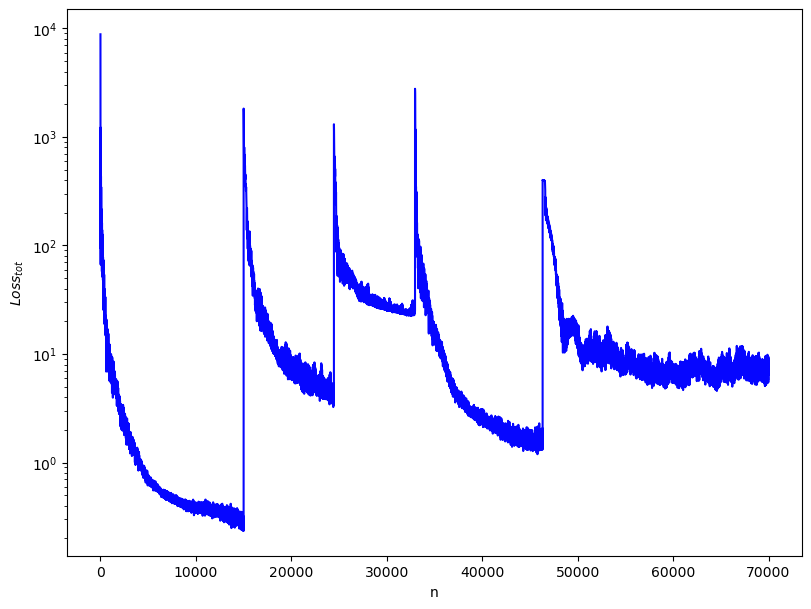

In [2]:
#loss_tot随训练次数的变化
plt.figure(figsize = (8,6))
SH_Loss = [i.detach().numpy() for i in loss_history[0]]
plt.semilogy(SH_Loss, '-b', alpha=0.975)
plt.tight_layout()
# x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
# y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$Loss_{tot}$');plt.xlabel('n')
plt.show()








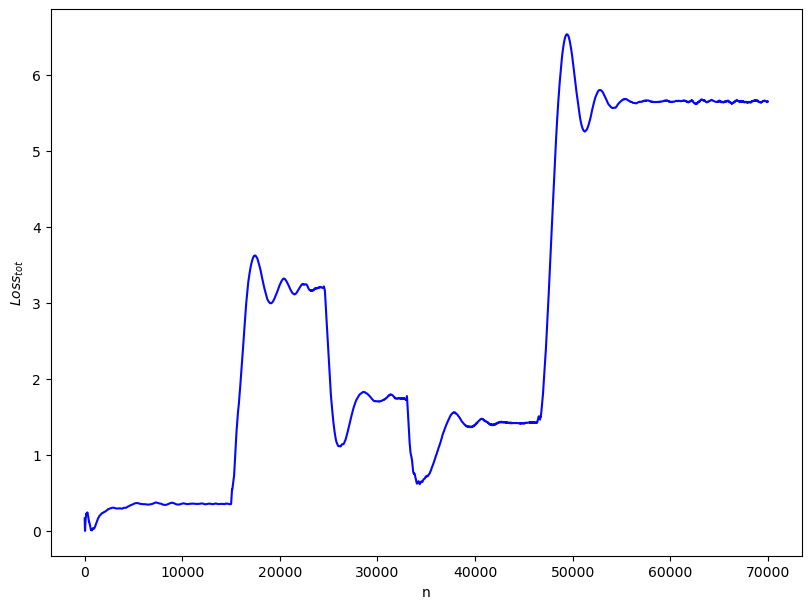

In [3]:
# 能量
plt.figure(figsize = (8,6))
#En_history = [i.detach().numpy() for i in loss_history[1]]
En_history=loss_history[1]
plt.plot(En_history, '-b', alpha=0.975)
plt.tight_layout()
# x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
# y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$Loss_{tot}$');plt.xlabel('n')
plt.show()

3.1977016925811768
[0.3540586829185486, 1.4263302087783813, 2.995703935623169, 3.1977016925811768, 4.98598051071167, 5.650629043579102]


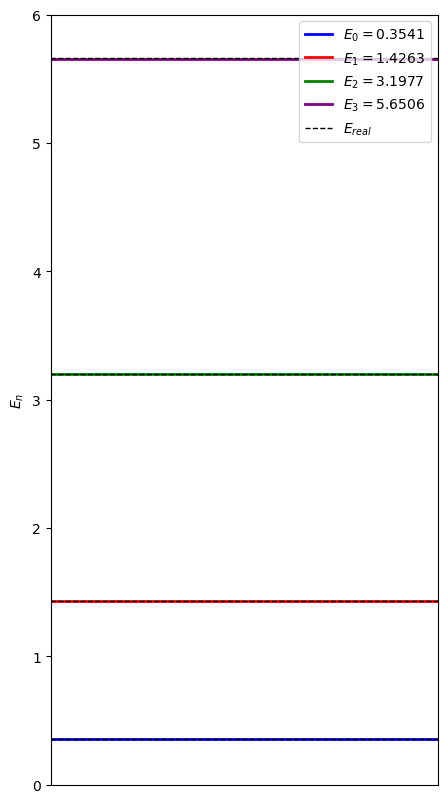

In [4]:
# 能级
print(dic[3][2])
E0=dic[0][2]
E1=dic[1][2]
E2=dic[2][2]
E3=dic[3][2]
E4=dic[4][2]
E5=dic[5][2]
# 能级值列表
energies = [E0, E1, E2, E3,E4,E5]
print(energies)
levels = range(len(energies))  # 能级的编号

# 绘制能级图
plt.figure(figsize=(5, 10))


plt.axhline(y=E0, xmin=-1, xmax=1, color='b', linewidth=2)
plt.axhline(y=E1, xmin=-1, xmax=1, color='r', linewidth=2)
plt.axhline(y=E3, xmin=-1, xmax=1, color='g', linewidth=2)
plt.axhline(y=E5, xmin=-1, xmax=1, color='purple', linewidth=2)
plt.axhline(y=0.3571, xmin=-1, xmax=1, color='k', linewidth=1,linestyle='--')
plt.axhline(y=1.4264, xmin=-1, xmax=1, color='k', linewidth=1,linestyle='--')
plt.axhline(y=3.2003, xmin=-1, xmax=1, color='k', linewidth=1,linestyle='--')
plt.axhline(y=5.6646, xmin=-1, xmax=1, color='k', linewidth=1,linestyle='--')


plt.ylabel(r'$E_n$')

plt.xlim(-1.5, 1.5)  # 设置x轴范围
plt.ylim(0,6)  # 设置y轴范围
plt.legend([f'$E_0={E0:.4f}$',f'$E_1={E1:.4f}$',f'$E_2={E3:.4f}$',f'$E_3={E5:.4f}$','$E_{real}$'])
plt.xticks([])
plt.show()


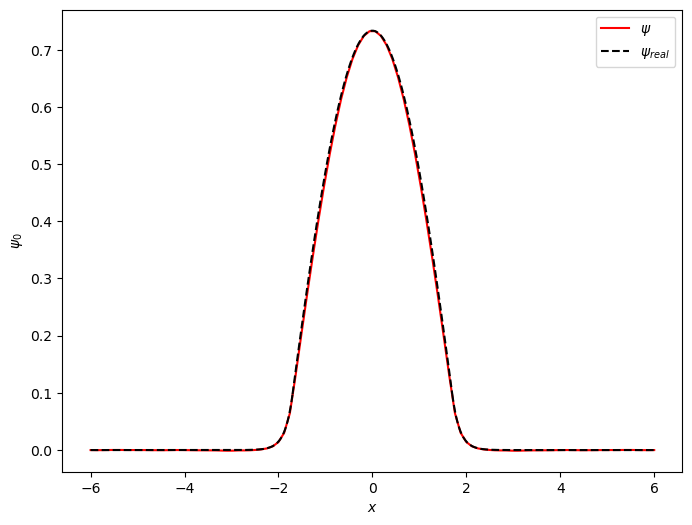

In [5]:
# 绘制psi_0，对psi的幅值进行了缩放
plt.figure(figsize = (8,6))
x = torch.linspace(-6, 6, 100).reshape(-1, 1)
psy=a.parametricSolutions(x,dic[0][0])
psy = [i.detach().numpy()/10.1 for i in psy]


plt.plot(x, psy,'r')
x1=np.linspace(-1.7, 1.7, 100)
y1=0.7333*np.cos(0.8452*x1)
x2=np.linspace(-6, -1.7, 200)
y2=4181.94*np.exp(6.2717*x2)
x3=np.linspace(1.7, 6, 200)
y3=4181.94*np.exp(-6.2717*x3)
plt.plot(x1, y1, 'k--')  # 第一个区间的黑色虚线
plt.plot(x2, y2, 'k--')  # 第二个区间的黑色虚线
plt.plot(x3, y3, 'k--')  # 第三个区间的黑色虚线
plt.ylabel(r'$\psi_0$')  # 使用LaTeX格式的x轴标签
plt.xlabel(r'$x$')  # 使用LaTeX格式的y轴标签
plt.legend(['$\psi$','$\psi_{real}$'])
plt.show()

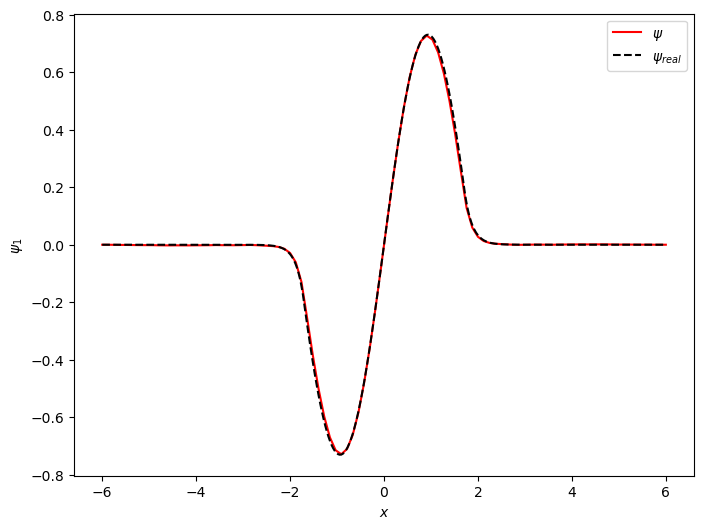

In [10]:
# 绘制psi_1，对psi的幅值进行了缩放

plt.figure(figsize = (8,6))
x = torch.linspace(-6, 6, 100).reshape(-1, 1)
psy=a.parametricSolutions(x,dic[1][0])
psy = [-i.detach().numpy()/10.1 for i in psy]

plt.plot(x, psy,'r')
x1=np.linspace(-1.7, 1.7, 100)
y1=0.7307*np.sin(1.6809*x1)
x2=np.linspace(-6, -1.7, 200)
y2=-6484.9*np.exp(6.0959*x2)
x3=np.linspace(1.7, 6, 200)
y3=6484.9*np.exp(-6.0959*x3)
plt.plot(x1, y1, 'k--')  # 第一个区间的黑色虚线
plt.plot(x2, y2, 'k--')  # 第二个区间的黑色虚线
plt.plot(x3, y3, 'k--')  # 第三个区间的黑色虚线
plt.legend(['$\psi$','$\psi_{real}$'])
plt.ylabel(r'$\psi_1$')  # 使用LaTeX格式的x轴标签
plt.xlabel(r'$x$')  # 使用LaTeX格式的y轴标签
plt.show()



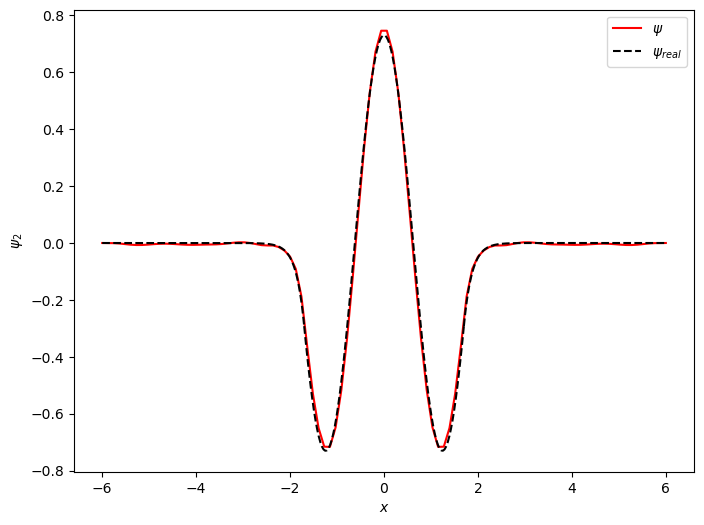

In [7]:
# 绘制psi_2，对psi的幅值进行了缩放
plt.figure(figsize = (8,6))
x = torch.linspace(-6, 6, 100).reshape(-1, 1)
psy=a.parametricSolutions(x,dic[2][0])
psy = [i.detach().numpy()/10 for i in psy]
plt.plot(x, psy,'r')
x1=np.linspace(-1.7, 1.7, 100)
y1=0.7307*np.cos(2.5299*x1)
x2=np.linspace(-6, -1.7, 200)
y2=-5560.38*np.exp(5.7961*x2)
x3=np.linspace(1.7, 6, 200)
y3=-5560.38*np.exp(-5.7961*x3)
plt.plot(x1, y1, 'k--')  # 第一个区间的黑色虚线
plt.plot(x2, y2, 'k--')  # 第二个区间的黑色虚线
plt.plot(x3, y3, 'k--')  # 第三个区间的黑色虚线
plt.legend(['$\psi$','$\psi_{real}$'])
plt.ylabel(r'$\psi_2$')  # 使用LaTeX格式的x轴标签
plt.xlabel(r'$x$')  # 使用LaTeX格式的y轴标签
plt.show()



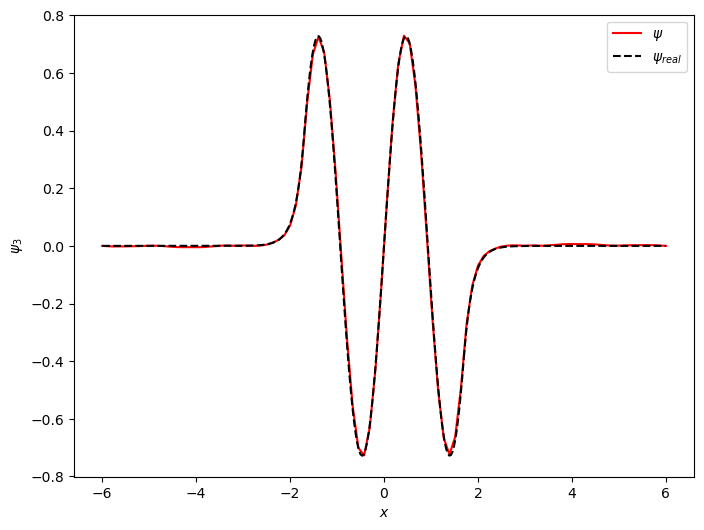

In [9]:
# 绘制psi_3，对psi的幅值进行了缩放
plt.figure(figsize = (8,6))
x = torch.linspace(-6, 6, 100).reshape(-1, 1)
psy=a.parametricSolutions(x,dic[5][0])
psy = [-i.detach().numpy()/10 for i in psy]
plt.plot(x, psy,'r')
x1=np.linspace(-1.7, 1.7, 100)
y1=0.7280*np.sin(3.366*x1)
x2=np.linspace(-6, -1.7, 200)
y2=3493.09*np.exp(5.3571*x2)
x3=np.linspace(1.7, 6, 200)
y3=-3493.09*np.exp(-5.3571*x3)
plt.plot(x1, y1, 'k--')  # 第一个区间的黑色虚线
plt.plot(x2, y2, 'k--')  # 第二个区间的黑色虚线
plt.plot(x3, y3, 'k--')  # 第三个区间的黑色虚线
plt.legend(['$\psi$','$\psi_{real}$'])
plt.ylabel(r'$\psi_3$')  # 使用LaTeX格式的x轴标签
plt.xlabel(r'$x$')  # 使用LaTeX格式的y轴标签
plt.show()